# ClimSim: Metrics calculation and visualization

Author: Sungduk Yu\
Last update: Wed 16 Aug 2023 04:52:19 PM PDT\
Description:
- This script calculates evaluation three metrics (MAE, R2, RMSE) in Part 1 and generates tables and figures for ClimSim manuscript in Part 2.\
- CRPS is calculated by a separate python script ("crps_clean.py" written by bhouri0412). In Part 2, presaved CRPS metrics as npy files are read and visualized. 

Input:
 - model_name: a string, model name
 - fn_x_true: npy file name for true input
 - fn_y_true: npy file name for true output
 - fn_y_pred: npy file name for model prediction
 - fn_grid: netcdif file name for grid information
 - fn_mli_mean, fn_mli_min, fn_mli_max: netcdf file names for input normalization coefficients (mean, min, max)
 - fn_mlo_scale: netcdf file name for output scaling coefficients.
 - fn_save_metrics: csv file name for saving output
 - fn_save_metrics_avg: csv file name for saving output (avg over the level dimension)

Output:
- calculated metrics as csv file with names set in fn_save_metrics and fn_save_metrics_avg 

# <PART 1> Calculate metrics and save them into a csv file

## Change file names [user input here only!]

In [1]:
FN_MODEL_OUTPUT = {'MLP':  './model_outputs/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy',
                   'RPN':  './model_outputs/rpn_pred_v1_stride6.npy',
                   'CNN':  './model_outputs/val_predict_cnn_reshaped_stride6_FINAL.npy',
                   'cVAE': './model_outputs/cvae.h5',
                   'HSR': './model_outputs/hsr_preds_bestcrps.h5',
                   'ED': './model_outputs/ED_ClimSIM_1_3_pred.npy'
                  }

In [2]:
# model name
# (model name is used for the output)
model_name = 'MLP'

# input of validation dataset (npy)
fn_x_true = '../npy_data_conversion/npy_files/val_input_stride6.npy'

# true output of validation dataset (npy)
fn_y_true = '../npy_data_conversion/npy_files/val_target_stride6.npy'

# Model predicted output of varlidation dataset (npy)
fn_y_pred = FN_MODEL_OUTPUT[model_name]

# model grid information (nc)
fn_grid = '../grid_info/E3SM-MMF_ne4_grid-info.orig.nc'

# normalization scale factors (nc)
fn_mli_mean  = '../norm_factors/mli_mean.nc'
fn_mli_min   = '../norm_factors/mli_min.nc'
fn_mli_max   = '../norm_factors/mli_max.nc'
fn_mlo_scale = '../norm_factors/mlo_scale.nc'

# fn_save_output
fn_save_metrics = f'./metrics/{model_name}.metrics.csv'
fn_save_metrics_avg = f'./metrics/{model_name}.metrics.lev-avg.csv'

## Set energy conversion scale factors

We want to convert all output variables to a common energy unit, e.g., W/m2.

Energy unit conversion
 - "dT/dt" [K/s] * cp [J/kg/K] * dp/g [kg/m2]   -> [W/m2]
 - "dQ/dt" [kg/kg/s] * lv [J/kg] * dp/g [kg/m2] -> [W/m2]
 - "PRECC" [m/s] * lv [J/kg]  * rho_h2o [kg/m3] -> [W/m2] 
 
(for dT/dt and dQ/dt, it should be "dp/g-weighted" vertical integration, not vertical averaging.)

In [3]:
# physical constatns from (E3SM_ROOT/share/util/shr_const_mod.F90)
grav    = 9.80616    # acceleration of gravity ~ m/s^2
cp      = 1.00464e3  # specific heat of dry air   ~ J/kg/K
lv      = 2.501e6    # latent heat of evaporation ~ J/kg
lf      = 3.337e5    # latent heat of fusion      ~ J/kg
ls      = lv + lf    # latent heat of sublimation ~ J/kg
rho_air = 101325./ (6.02214e26*1.38065e-23/28.966) / 273.15 # density of dry air at STP  ~ kg/m^3
                                                            # ~ 1.2923182846924677
                                                            # SHR_CONST_PSTD/(SHR_CONST_RDAIR*SHR_CONST_TKFRZ)
                                                            # SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
                                                            # SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
rho_h20 = 1.e3       # density of fresh water     ~ kg/m^ 3

vars_mlo_energy_conv = {'ptend_t':cp,
                        'ptend_q0001':lv,
                        'cam_out_NETSW':1.,
                        'cam_out_FLWDS':1.,
                        'cam_out_PRECSC':lv*rho_h20,
                        'cam_out_PRECC':lv*rho_h20,
                        'cam_out_SOLS':1.,
                        'cam_out_SOLL':1.,
                        'cam_out_SOLSD':1.,
                        'cam_out_SOLLD':1.
                       }
vars_longname=\
{'ptend_t':'Heating tendency, ∂T/∂t',
 'ptend_q0001':'Moistening tendency, ∂q/∂t',
 'cam_out_NETSW':'Net surface shortwave flux, NETSW',
 'cam_out_FLWDS':'Downward surface longwave flux, FLWDS',
 'cam_out_PRECSC':'Snow rate, PRECSC',
 'cam_out_PRECC':'Rain rate, PRECC',
 'cam_out_SOLS':'Visible direct solar flux, SOLS',
 'cam_out_SOLL':'Near-IR direct solar flux, SOLL',
 'cam_out_SOLSD':'Visible diffused solar flux, SOLSD',
 'cam_out_SOLLD':'Near-IR diffused solar flux, SOLLD'}

## Main

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob

# set dimemsion names for xarray datasets
dim_name_level  = 'lev'
dim_name_sample = 'sample'

In [5]:
# load input dataset
x_true = np.load(fn_x_true).astype(np.float64)
y_true = np.load(fn_y_true).astype(np.float64)
if fn_y_pred[-3:] == '.h5':
    y_pred = xr.open_dataset(fn_y_pred)['pred'].values
else:
    y_pred = np.load(fn_y_pred).astype(np.float64)
N_samples = y_pred.shape[0] 

# load norm/scale factors
mlo_scale = xr.open_dataset(fn_mlo_scale)
mli_mean  = xr.open_dataset(fn_mli_mean)
mli_min   = xr.open_dataset(fn_mli_min)
mli_max   = xr.open_dataset(fn_mli_max)

In [6]:
# load grid information
ds_grid = xr.open_dataset(fn_grid) # has ncol:384
N_ncol = len(ds_grid['ncol']) # length of ncol dimension (nlat * nlon)

# make area-weights
ds_grid['area_wgt'] = ds_grid['area'] / ds_grid['area'].mean('ncol')

# map ds_grid's ncol dimension -> the N_samples dimension of npy-loayd arrays (e.g., y_pred)
to_xarray = {'area_wgt': (dim_name_sample,np.tile(ds_grid['area_wgt'], int(N_samples/len(ds_grid['ncol'])))),
            }
to_xarray = xr.Dataset(to_xarray)

# add nsample-mapped grid variables back to ds_grid
ds_grid = xr.merge([ds_grid  [['P0', 'hyai', 'hyam','hybi','hybm','lat','lon','area']],
                    to_xarray[['area_wgt']]])

### Pack np arrays to xarray dataset
(This is only to use Xarray for metric calculations.)

In [7]:
# list of ML output variables
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC',
            'cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD'] # mlo mean ML output.

# length of each variable
# (make sure that the order of variables are correct)
vars_mlo_len = {'ptend_t':60,
                'ptend_q0001':60,
                'cam_out_NETSW':1,
                'cam_out_FLWDS':1,
                'cam_out_PRECSC':1,
                'cam_out_PRECC':1,
                'cam_out_SOLS':1,
                'cam_out_SOLL':1,
                'cam_out_SOLSD':1,
                'cam_out_SOLLD':1
               }

# map the length of dimension to the name of dimension
len_to_dim = {60:dim_name_level,
              N_samples: dim_name_sample}

In [8]:
# Here, we first construct a dictionary of {var name: (dimension name, array-like)},
# then, map the dictionary to an Xarray Dataset.
# (ref: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html)

DS = {}

for kds in ['true', 'pred']:
    if kds=='true':
        work = y_true
    elif kds=='pred':
        work = y_pred

    # [1] Construct dictionary for xarray dataset
    #     format is key for variable name /
    #               value for a turple of (dimension names, data).
    to_xarray = {}
    for k, kvar in enumerate(vars_mlo):

        # length of variable (ie, number of levels)
        kvar_len = vars_mlo_len[kvar]

        # set dimensions of variable
        if kvar_len == 60:
            kvar_dims = (dim_name_sample, dim_name_level)
        elif kvar_len == 1:
            kvar_dims = dim_name_sample

        # set start and end indices of variable in the loaded numpy array
        # then, add 'kvar':(kvar_dims, <np_array>) to dictionary
        if k==0: ind1=0
        ind2 = ind1 + kvar_len

        # scaled output
        kvar_data = np.squeeze(work[:,ind1:ind2])
        # unscaled output
        kvar_data = kvar_data / mlo_scale[kvar].values

        to_xarray[kvar] = (kvar_dims, kvar_data)

        ind1 = ind2

    # [2] convert dict to xarray dataset
    DS[kds] = xr.Dataset(to_xarray)

    # [3] add surface pressure ('state_ps') from ml input
    # normalized ps
    state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
    # denormalized ps
    state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']
    DS[kds]['state_ps'] = state_ps

    # [4] add grid information
    DS[kds] = xr.merge([DS[kds], ds_grid])

    # [5] add pressure thickness of each level, dp
    # FYI, in a hybrid sigma vertical coordinate system, pressure at level z is
    # P[x,z] = hyam[z]*P0 + hybm[z]*PS[x,z],
    # where, hyam and hybm are 
    tmp = DS[kds]['P0']*DS[kds]['hyai'] + DS[kds]['state_ps']*DS[kds]['hybi']
    tmp = tmp.isel(ilev=slice(1,61)).values - tmp.isel(ilev=slice(0,60)).values
    tmp = tmp.transpose()
    DS[kds]['dp'] = xr.DataArray(tmp, dims=('sample', 'lev'))

    # [6] break (sample) to (ncol,time)
    N_timestep = int(N_samples/N_ncol)
    dim_ncol     = np.arange(N_ncol)
    dim_timestep = np.arange(N_timestep)
    new_ind = pd.MultiIndex.from_product([dim_timestep, dim_ncol],
                                         names=['time', 'ncol'])
    DS[kds] = DS[kds].assign_coords(sample=new_ind).unstack('sample')

del work, to_xarray, y_true, y_pred, x_true, state_ps, tmp

### 1) unit conversion / area weighting / vertical weighting

In [9]:
# [1] Weight vertical levels by dp/g that is equivalent to a mass of air within a grid cell per unit area [kg/m2]
# [2] Weight horizontal area of each grid cell by a[x]/mean(a[x]).
# [3] Unit conversion to a common energy unit

DS_ENERGY = {}
for kds in ['true','pred']:
    # Make a copy to keep original dataset
    DS_ENERGY[kds] = DS[kds].copy(deep=True)

    # vertical weighting / area weighting / unit conversion
    for kvar in vars_mlo:

        # [1] weight vertical levels by dp/g
        #     ONLY for vertically-resolved variables, e.g., ptend_{t,q0001}
        # dp/g = - \rho * dz
        if vars_mlo_len[kvar] == 60:
            DS_ENERGY[kds][kvar] = DS_ENERGY[kds][kvar] * DS_ENERGY[kds]['dp']/grav

        # [2] weight area
        #     for ALL variables
        DS_ENERGY[kds][kvar] = DS_ENERGY[kds]['area_wgt'] * DS_ENERGY[kds][kvar]

        # [3] convert units to W/m2
        #     for variables with different units, e.g., ptend_{t,q0001}, precsc, precc
        DS_ENERGY[kds][kvar] =  vars_mlo_energy_conv[kvar] * DS_ENERGY[kds][kvar]

### 2) Calculate metrics based on globally-averaged model output

In [10]:
all_metrics = ['MAE','RMSE','R2']

In [11]:
# A. Calculate metrics
# After this step,
# ptend_{t,q0001} have [ncol, lev] dimension;
# and the rest variables have [ncol] dimension.

# if spatial analysis is desired (e.g., R2 distribution on global map or on latitude-level plane),
# the metrics at this step should be used.


# Select only ML output varibles
DS_ENERGY[kds] = DS_ENERGY[kds][vars_mlo]

# Caclulate 3 metrics
Metrics = {}
Metrics['MAE']  = (np.abs(DS_ENERGY['true']   - DS_ENERGY['pred'])).mean('time')
Metrics['RMSE'] = np.sqrt(((DS_ENERGY['true'] - DS_ENERGY['pred'])**2.).mean('time'))
Metrics['R2'] = 1 - ((DS_ENERGY['true'] - DS_ENERGY['pred']                    )**2.).sum('time')/\
                    ((DS_ENERGY['true'] - DS_ENERGY['true'].mean('time'))**2.).sum('time')

In [12]:
# B. Make horizontal mean.
# After this step,
# ptend_{t,q0001} have [lev] dimension;
# and the rest variables have zero dimensions, i.e., scalars.

for kmetric in all_metrics:
    Metrics[kmetric] = Metrics[kmetric].mean('ncol') # simple mean

In [13]:
# C-1. Save the result after B.
# to save in a table format as a csv file, the level dimensions are flattened.

Metrics_stacked = {}
for kmetric in all_metrics:
    Metrics_stacked[kmetric] = Metrics[kmetric].to_stacked_array('ml_out_idx', sample_dims='', name=kmetric)


# save the output
work = pd.DataFrame({'MAE':  Metrics_stacked['MAE'].values,
                     'RMSE': Metrics_stacked['RMSE'].values,
                     'R2':   Metrics_stacked['R2'].values}
                    )
work.index.name = 'output_idx'

# fn_save_metrics = f'./metrics/{model_name}.metrics.csv'
work.to_csv(fn_save_metrics)
work

,MAE,RMSE,R2
output_idx,,,
0,0.002488,0.005218,0.897846
1,0.004997,0.009940,0.934334
2,0.008768,0.013675,0.966718
3,0.014756,0.021097,0.982648
4,0.023048,0.030524,0.993642
...,...,...,...
123,34.333065,72.876357,-38.685671
124,7.970805,17.403315,0.961380
125,10.299178,21.954437,0.947612


In [14]:
# C-2. Save the result after vertical averaging.
# After this step,
# ptend_{t,q0001} also have zero dimensions, i.e., scalars;

# Then, the results are saved to a csv file.
# This csv file will be used for generating plots.

Metrics_vert_avg = {}
for kmetric in all_metrics:
    Metrics_vert_avg[kmetric] = Metrics[kmetric].mean('lev')
    Metrics_vert_avg[kmetric] = Metrics_vert_avg[kmetric].mean('ilev') # remove dummy dim

# save the output
work = pd.DataFrame({'MAE':  Metrics_vert_avg['MAE'].to_pandas(),
                     'RMSE': Metrics_vert_avg['RMSE'].to_pandas(),
                     'R2':   Metrics_vert_avg['R2'].to_pandas()}
                    )
work.index.name = 'Variable'
    
# fn_save_metrics_avg = f'./metrics/{model_name}.metrics.lev-avg.csv'
work.to_csv(fn_save_metrics_avg)
work

,MAE,RMSE,R2
Variable,,,
ptend_t,2.682765,4.420904,0.588987
ptend_q0001,4.494752,7.321821,-inf
cam_out_NETSW,13.360915,26.707551,0.982684
cam_out_FLWDS,5.224468,6.968642,0.924299
cam_out_PRECSC,2.683915,4.733680,-inf
cam_out_PRECC,34.333065,72.876357,-38.685671
cam_out_SOLS,7.970805,17.403315,0.961380
cam_out_SOLL,10.299178,21.954437,0.947612
cam_out_SOLSD,4.533141,9.420306,0.955713


## Check the performance variance across top 160 MLP models (out of ~8,000 tuning trials)

In [15]:
# vertical avg
METRIC_MLP160 = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        csv_path  = f'./metrics_{kmodel}-top160/*.metrics.lev-avg.csv'
                    # this path contains 160 csv files for top 160 MLP models
        csv_files = sorted(glob.glob(csv_path))
        df_list = (pd.read_csv(kf, index_col=0)[kmetric] for kf in csv_files)
        METRIC_MLP160[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
METRIC_MLP160_STAT = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160_STAT[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        df_list = {'mean': METRIC_MLP160[kmetric][kmodel].mean(axis=1),
                   'median': METRIC_MLP160[kmetric][kmodel].median(axis=1),
                   'std': METRIC_MLP160[kmetric][kmodel].std(axis=1),
                   'p05': METRIC_MLP160[kmetric][kmodel].quantile(0.05,axis=1),
                   'p10': METRIC_MLP160[kmetric][kmodel].quantile(0.10,axis=1),
                   'p25': METRIC_MLP160[kmetric][kmodel].quantile(0.25,axis=1),
                   'p75': METRIC_MLP160[kmetric][kmodel].quantile(0.75,axis=1),
                   'p90': METRIC_MLP160[kmetric][kmodel].quantile(0.90,axis=1),
                   'p95': METRIC_MLP160[kmetric][kmodel].quantile(0.95,axis=1),
                   'min': METRIC_MLP160[kmetric][kmodel].min(axis=1),
                   'max': METRIC_MLP160[kmetric][kmodel].max(axis=1),
                  }
        METRIC_MLP160_STAT[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
# Warning message will generate due to nans and infs in R2.

/global/homes/s/sungduk/.conda/envs/tf_conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/global/homes/s/sungduk/.conda/envs/tf_conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [16]:
# without vertical avg
METRIC_MLP160_LEV = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160_LEV[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        csv_path  = f'./metrics_{kmodel}-top160/*.metrics.csv'
                    # this path contains 160 csv files for top 160 MLP models
        csv_files = sorted(glob.glob(csv_path))
        df_list = (pd.read_csv(kf, index_col=0)[kmetric] for kf in csv_files)
        METRIC_MLP160_LEV[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
METRIC_MLP160_STAT_LEV = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160_STAT_LEV[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        df_list = {'mean': METRIC_MLP160_LEV[kmetric][kmodel].mean(axis=1),
                   'median': METRIC_MLP160_LEV[kmetric][kmodel].median(axis=1),
                   'std': METRIC_MLP160_LEV[kmetric][kmodel].std(axis=1),
                   'p05': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.05,axis=1),
                   'p10': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.10,axis=1),
                   'p25': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.25,axis=1),
                   'p75': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.75,axis=1),
                   'p90': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.90,axis=1),
                   'p95': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.95,axis=1),
                   'min': METRIC_MLP160_LEV[kmetric][kmodel].min(axis=1),
                   'max': METRIC_MLP160_LEV[kmetric][kmodel].max(axis=1),
                  }
        METRIC_MLP160_STAT_LEV[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
# Warning message will generate due to nans and infs in R2.

/global/homes/s/sungduk/.conda/envs/tf_conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/global/homes/s/sungduk/.conda/envs/tf_conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# <PART 2> Load pre-saved csv files and make figures

## Plot metrics (model intercomparison)

The plotting requires presaved csv files.\
One csv files per one model.

In [17]:
# file names for saved metrics (from C-2)
fn_metrics = {'CNN':  './metrics/CNN.metrics.lev-avg.csv',
              'MLP':  './metrics/MLP.metrics.lev-avg.csv',
              'RPN':  './metrics/RPN.metrics.lev-avg.csv',
              'cVAE': './metrics/cVAE.metrics.lev-avg.csv',
              'HSR':  './metrics/HSR.metrics.lev-avg.csv',
              'ED':  './metrics/ED.metrics.lev-avg.csv',
             }

# file names for saved metrics (from C-1)
fn_metrics_stacked = {'CNN':  './metrics/CNN.metrics.csv',
                      'MLP':  './metrics/MLP.metrics.csv',
                      'RPN':  './metrics/RPN.metrics.csv',
                      'cVAE': './metrics/cVAE.metrics.csv',
                      'HSR':  './metrics/HSR.metrics.csv',
                      'ED':  './metrics/ED.metrics.csv',
                     }

# assign bar colors
# https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
lc_model = {'CNN':  '#0072B2',
            'HSR':  '#E69F00',
            'MLP':  '#2B2B2B', #'#882255',
            'RPN':  '#009E73',
            'cVAE': '#D55E00',
            'ED':   '#882255' #'#56B4E9'
           }

# variable short name
var_short_name = {'ptend_t': 'dT/dt',
                  'ptend_q0001':'dq/dt',
                  'cam_out_NETSW':  'NETSW',
                  'cam_out_FLWDS':  'FLWDS',
                  'cam_out_PRECSC': 'PRECSC',
                  'cam_out_PRECC': 'PRECC',
                  'cam_out_SOLS': 'SOLS',
                  'cam_out_SOLL': 'SOLL',
                  'cam_out_SOLSD': 'SOLSD',
                  'cam_out_SOLLD': 'SOLLD',
                 }

# map 'output_idx' (fn_metrics_stacked) and 'variables' (fn_metrics)
var_idx = {}
var_idx['ptend_t']      = (0,60)
var_idx['ptend_q0001']  = (60,120)
var_idx['surface_vars'] = (120,128)

In [18]:
# CRPS metrics
fn_crps = {'RPN':  './metrics_crps/RPN_CRPS.npy',
           'cVAE': './metrics_crps/cVAE_CRPS.npy',
           'HSR':  './metrics_crps/HSR_CRPS.npy',
          }

### plot 1. level aggregated metrics
### *This figure is included in the main text*

In [19]:
# ordering models in a plot
plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE'] 
plot_this_models_crps = ['HSR', 'RPN', 'cVAE']

# which metrics to plot?
plot_this_metrics = ['MAE', 'RMSE', 'R2', 'CRPS']

# subpanel score
abc='abcdefg'

In [20]:
# Packing metrics of different models into one Pandas dataframe

PLOTDATA = {}
for kmodel in plot_this_models:
    # MSE, R2, RMSE
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)
    
    # CRPS
    if kmodel in fn_crps.keys():
        work = np.load(fn_crps[kmodel])
        work = [work[slice(*var_idx['ptend_t'])].mean(),     # vertical_avg
                work[slice(*var_idx['ptend_q0001'])].mean(), # vertical_avg
                *work[slice(*var_idx['surface_vars'])],
               ]
        PLOTDATA[kmodel]['CRPS'] = work
    else:
        continue
    

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    if kmetric in ['CRPS']:
        k_plot_this_models = plot_this_models_crps
    if kmetric in ['MAE', 'R2', 'RMSE']:
        k_plot_this_models = plot_this_models
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in k_plot_this_models],
                                               index=k_plot_this_models
                                              )

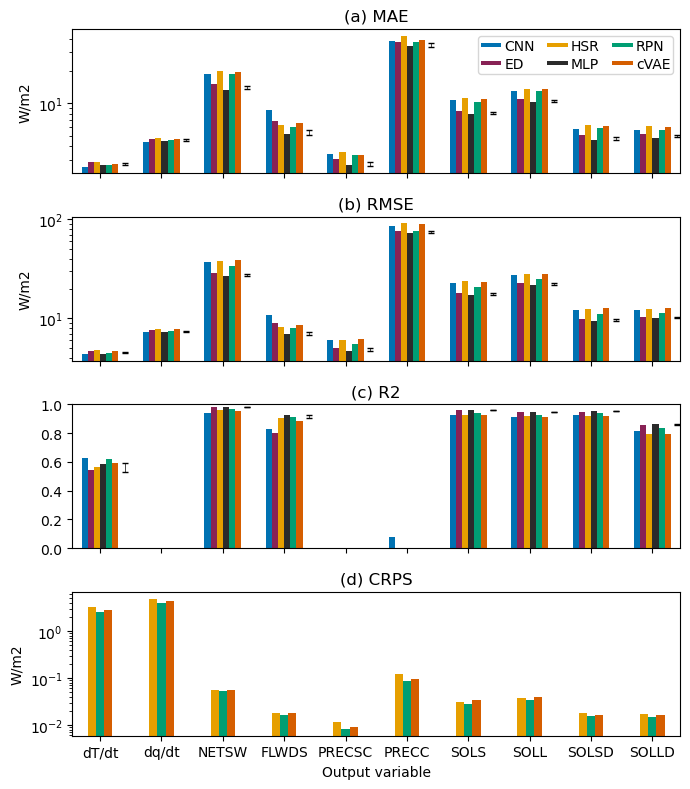

In [21]:


fig, _ax = plt.subplots(nrows  = len(plot_this_metrics), 
                        sharex = True)

for k, kmetric in enumerate(plot_this_metrics):
    ax = _ax[k]
    plotdata = PLOTDATA_by_METRIC[kmetric]
    plotdata = plotdata.rename(columns=var_short_name)
    plotdata = plotdata.transpose()
    plotdata.plot.bar(color = [lc_model[kmodel] for kmodel in plotdata.keys()],
                      width = .4 if kmetric=='CRPS' else .6,
                      legend = False,
                      ax=ax)

    ax.set_title(f'({abc[k]}) {kmetric}')
    ax.set_xlabel('Output variable')
    ax.set_xticklabels(plotdata.index, rotation=0, ha='center')
    
    # top-160 MLP spread
    if True and (kmetric in METRIC_MLP160_STAT.keys()):
        errbar_model = 'MLPv1'
        x_off       = 0.4
        plot_x      = np.arange(len(plotdata)) + x_off
        plot_m      = METRIC_MLP160_STAT[kmetric][errbar_model]['median']
        plot_lower  = plot_m - METRIC_MLP160_STAT[kmetric][errbar_model]['p05'] 
        plot_upper  = METRIC_MLP160_STAT[kmetric][errbar_model]['p95'] - plot_m
        
        ax.errorbar(plot_x, plot_m, yerr=[plot_lower,plot_upper],
                    color='k', capsize=2.5, ls='none', lw=.5)
    
    # no units for R2
    if kmetric != 'R2':
        ax.set_ylabel('W/m2')
    
    # not plotting negative R2 values
    if kmetric == 'R2':
        ax.set_ylim(0,1)
        
    # log y scale
    if kmetric != 'R2':
        ax.set_yscale('log')

    fig.set_size_inches(7, 8)

_ax[0].legend(ncols=3, columnspacing=.9, labelspacing=.3,
              handleheight=.07, handlelength=1.5, handletextpad=.2,
              borderpad=.2,
              loc='upper right')

fig.tight_layout()

### plot 2. vertical profile of metrics for tendency variables
### *This figure is included in the SI*

In [22]:
# tell which models and which metrics you want to plot
plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE'] 
plot_this_models_crps = ['HSR', 'RPN', 'cVAE']

plot_this_metrics = ['MAE', 'RMSE', 'R2', 'CRPS']

In [23]:
# Packing metrics of different models into one Pandas dataframe

PLOTDATA = {}
for kmodel in plot_this_models:
    # MSE, R2, RMSE
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)
    
    # CRPS
    if kmodel in fn_crps.keys():
        work = np.load(fn_crps[kmodel])
        work = [*work[slice(*var_idx['ptend_t'])],
                *work[slice(*var_idx['ptend_q0001'])],
                *work[slice(*var_idx['surface_vars'])],
               ]
        PLOTDATA[kmodel]['CRPS'] = work
    else:
        continue
    

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    if kmetric in ['CRPS']:
        k_plot_this_models = plot_this_models_crps
    if kmetric in ['MAE', 'R2', 'RMSE']:
        k_plot_this_models = plot_this_models
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in k_plot_this_models],
                                               index=k_plot_this_models
                                              )

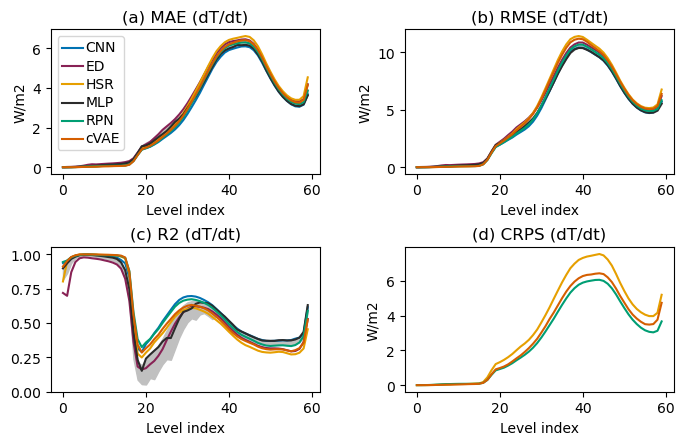

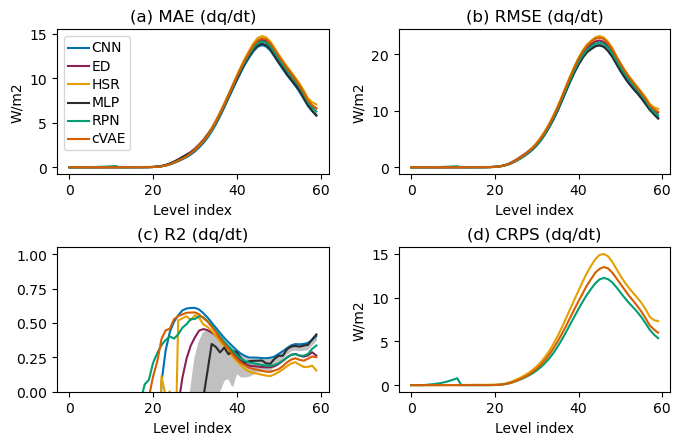

In [24]:
abc='abcdefg'
for kvar in ['ptend_t','ptend_q0001']:
    fig, _ax = plt.subplots(ncols=2, nrows=2)
    _ax = _ax.flatten()
    for k, kmetric in enumerate(plot_this_metrics):
        ax = _ax[k]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if kvar == 'ptend_q0001':
            plotdata.columns = plotdata.columns - 60
        if kvar=='ptend_q0001': # this is to keep the right x axis range.
            plotdata = plotdata.where(~np.isinf(plotdata),-999)
        plotdata = plotdata.transpose()
        plotdata.plot(color = [lc_model[kmodel] for kmodel in plotdata.keys()],
                      legend=False,
                      ax=ax,
                     )
        # top-160 MLP spread
        if True and (kmetric in METRIC_MLP160_STAT_LEV.keys()):
            errbar_model = 'MLPv1'
            plot_x     = np.arange(0,60)
            plot_lower = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p05']
            plot_lower = plot_lower.iloc[idx_start:idx_end]
            plot_upper = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p95']
            plot_upper = plot_upper.iloc[idx_start:idx_end]
            
            ax.fill_between(plot_x, plot_lower, plot_upper,
                            color='silver', zorder=-100)


        ax.set_xlabel('Level index')
        ax.set_title(f'({abc[k]}) {kmetric} ({var_short_name[kvar]})')
        if kmetric != 'R2':
            ax.set_ylabel('W/m2')

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)

    # legend
    _ax[0].legend(ncols=1, labelspacing=.3,
              handleheight=.07, handlelength=1.5, handletextpad=.2,
              borderpad=.3,
              loc='upper left')
    
    fig.tight_layout()
    fig.set_size_inches(7,4.5)

### plot 3. plot 1 and plot 2 together for MAE and R2
### *This figure is included in the main text*

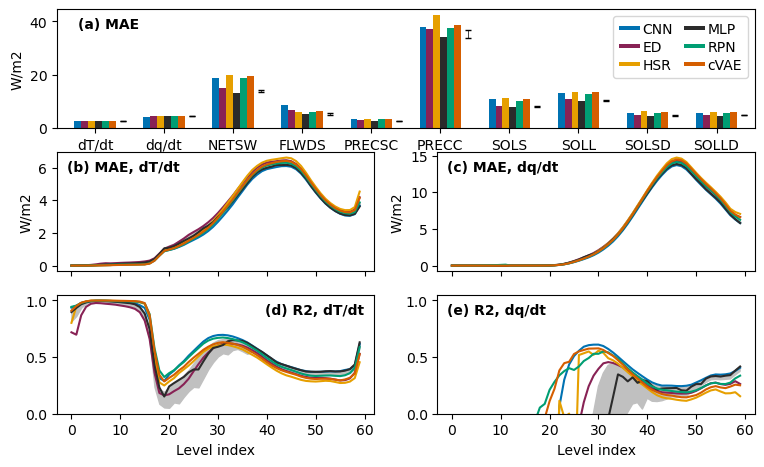

In [25]:
sw_log = False

abc='abbcdefghij'
# fig, _ax = plt.subplots(ncols=2, nrows=4,
#                         gridspec_kw={'height_ratios': [1.6,1,1,1]})

fig, _ax = plt.subplots(ncols=2, nrows=3)
gs = _ax[0, 0].get_gridspec()
# remove the underlying axes
for ax in _ax[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, 0:])



# top rows

plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE']
plot_this_metrics = ['MAE']

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )

ax = axbig
plotdata = PLOTDATA_by_METRIC[plot_this_metrics[0]]
plotdata = plotdata.rename(columns=var_short_name)
plotdata = plotdata.transpose()
plotdata.plot.bar(color=[lc_model[kmodel] for kmodel in plot_this_models],
                  legend = False,
                  width = 0.6,
                  ax=ax)
ax.set_xticklabels(plotdata.index, rotation=0, ha='center')
ax.set_xlabel('')
# ax.set_title(f'({abc[k]}) {kmetric}')
ax.set_ylabel('W/m2')

ax.text(0.03, 0.93, f'(a) {kmetric}', horizontalalignment='left',
       verticalalignment='top', transform=ax.transAxes,
       fontweight='demi')

if sw_log:
    ax.set_yscale('log')

ax.legend(ncols=2,
          columnspacing=.8,
          labelspacing=.3,
          handleheight=.1,
          handlelength=1.5,
          handletextpad=.2,
          borderpad=.4,
          frameon=True,
          loc='upper right')

# top-160 MLP spread
errbar_model = 'MLPv1'
x_off       = 0.4
plot_x      = np.arange(len(plotdata)) + x_off
plot_m      = METRIC_MLP160_STAT[plot_this_metrics[0]][errbar_model]['median']
plot_lower  = plot_m - METRIC_MLP160_STAT[plot_this_metrics[0]][errbar_model]['p05'] 
plot_upper  = METRIC_MLP160_STAT[plot_this_metrics[0]][errbar_model]['p95'] - plot_m


ax.errorbar(plot_x, plot_m, yerr=[plot_lower,plot_upper],
            color='k', capsize=2.5, ls='none', lw=.5)

# bottom rows

plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE']
lot_this_models = ['ED', 'HSR','MLP']
plot_this_metrics = ['MAE', 'R2']

var_idx = {}
var_idx['ptend_t'] = (0,60)
var_idx['ptend_q0001'] = (60,120)

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )


for kk, kvar in enumerate(['ptend_t','ptend_q0001']):
    for k, kmetric in enumerate(plot_this_metrics):
        ax = _ax[k+1, 0 if kvar=='ptend_t' else 1]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if kvar == 'ptend_q0001':
            plotdata.columns = plotdata.columns - 60
        if kvar=='ptend_q0001': # this is to keep the right x axis range.
            plotdata = plotdata.where(~np.isinf(plotdata),-999)
        plotdata.transpose()\
        .plot(color=[lc_model[kmodel] for kmodel in plot_this_models],
              legend=False,
              ax=ax,
             )

        # top-160 MLP spread
        if True and (kmetric in METRIC_MLP160_STAT_LEV.keys()):
            errbar_model = 'MLPv1'
            plot_x     = np.arange(0,60)
            plot_lower = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p05']
            plot_lower = plot_lower.iloc[idx_start:idx_end]
            plot_upper = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p95']
            plot_upper = plot_upper.iloc[idx_start:idx_end]
            
            ax.fill_between(plot_x, plot_lower, plot_upper,
                            color='silver', zorder=-100)

        #ax.set_title(f'({abc[k]}) {kmetric}')
        if k==0:
            ax.set_ylabel(f'W/m2')
            ax.set_xlabel('')
            ax.set_xticklabels('')
        elif k==1:
            ax.set_xlabel('Level index')

        
        if abc[kk+2*k+2] == 'd':
            ax.text(0.97, 0.93, f'({abc[kk+2*k+2]}) {kmetric}, {var_short_name[kvar]}', horizontalalignment='right',
                   verticalalignment='top', transform=ax.transAxes,
                   fontweight='demi')
        else:
            ax.text(0.03, 0.93, f'({abc[kk+2*k+2]}) {kmetric}, {var_short_name[kvar]}', horizontalalignment='left',
                   verticalalignment='top', transform=ax.transAxes,
                   fontweight='demi')

        if sw_log:
            ax.set_yscale('log')

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)

fig.set_size_inches(9,5.25)

### plot 4. scatter plot
(Make sure to run the cells upto Cell#8)

In [26]:
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import r2_score

In [27]:
# load model prediction and pack into a single dictionary.
DS_HIST = {}
for kmodel in ['true', 'CNN', 'ED', 'HSR', 'MLP', 'RPN', 'cVAE']:
           # make sure that 'true' should be the first entry
    if kmodel=='true':
        fn_y = '../npy_data_conversion/npy_files/val_target_stride6.npy'
        work = np.load(fn_y).astype(np.float64)
        fn_x = '../npy_data_conversion/npy_files/val_input_stride6.npy'
        x_true = np.load(fn_x).astype(np.float64)
    else:
        fn_y = FN_MODEL_OUTPUT[kmodel]
        if fn_y[-3:] == '.h5':
            work = xr.open_dataset(fn_y)['pred'].values
        else:
            work = np.load(fn_y).astype(np.float64)
    N_samples = work.shape[0] 

    # [1] Construct dictionary for xarray dataset
    #     format is key for variable name /
    #               value for a turple of (dimension names, data).
    to_xarray = {}
    for k, kvar in enumerate(vars_mlo):

        # length of variable (ie, number of levels)
        kvar_len = vars_mlo_len[kvar]

        # set dimensions of variable
        if kvar_len == 60:
            kvar_dims = (dim_name_sample, dim_name_level)
        elif kvar_len == 1:
            kvar_dims = dim_name_sample

        # set start and end indices of variable in the loaded numpy array
        # then, add 'kvar':(kvar_dims, <np_array>) to dictionary
        if k==0: ind1=0
        ind2 = ind1 + kvar_len

        # scaled output
        kvar_data = np.squeeze(work[:,ind1:ind2])
        # # unscaled output
        # kvar_data = kvar_data / mlo_scale[kvar].values

        to_xarray[kvar] = (kvar_dims, kvar_data)

        ind1 = ind2

    # [2] convert dict to xarray dataset
    DS_HIST[kmodel] = xr.Dataset(to_xarray)

    # [3] add surface pressure ('state_ps') from ml input
    # normalized ps
    state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
    # denormalized ps
    state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']
    DS_HIST[kmodel]['state_ps'] = state_ps

    # [4] add grid information
    DS_HIST[kmodel] = xr.merge([DS_HIST[kmodel], ds_grid])

    # [5] add pressure thickness of each level, dp
    # FYI, in a hybrid sigma vertical coordinate system, pressure at level z is
    # P[x,z] = hyam[z]*P0 + hybm[z]*PS[x,z],
    # where, hyam and hybm are 
    tmp = DS_HIST[kmodel]['P0']*DS_HIST[kmodel]['hyai'] \
          + DS_HIST[kmodel]['state_ps']*DS_HIST[kmodel]['hybi']
    tmp = tmp.isel(ilev=slice(1,61)).values - tmp.isel(ilev=slice(0,60)).values
    tmp = tmp.transpose()
    DS_HIST[kmodel]['dp'] = xr.DataArray(tmp, dims=('sample', 'lev'))

    # [6] break (sample) to (ncol,time)
    N_timestep = int(N_samples/N_ncol)
    dim_ncol     = np.arange(N_ncol)
    dim_timestep = np.arange(N_timestep)
    new_ind = pd.MultiIndex.from_product([dim_timestep, dim_ncol],
                                         names=['time', 'ncol'])
    DS_HIST[kmodel] = DS_HIST[kmodel].assign_coords(sample=new_ind).unstack('sample')

del work, to_xarray, x_true, state_ps, tmp

In [28]:
## PLOT ##
def plot_hexbin(kvar:str, klev=-1, 
                xmin=0., xmax=3., ymin=0., ymax=3.):
    fig = plt.figure()
    imgrid = ImageGrid(fig, 111,  # similar to subplot(111)
                       nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                       axes_pad=0.2,  # pad between axes in inch.
                       cbar_mode='single',
                       cbar_location='right',
                       cbar_pad=0.2,
                       aspect=True
                       )

    panel_id='abcdefg'
    plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE'] 
    for k, kmodel in enumerate(plot_this_models):

        # read data
        plotx = DS_HIST['true'][kvar]
        ploty = DS_HIST[kmodel][kvar]
        
        if klev >= 0:
            plotx = plotx.isel(lev=klev)
            ploty = ploty.isel(lev=klev)
            
        plotx = plotx.values
        ploty = ploty.values
        
        # metric calculation
        plotrmse = np.sqrt(((plotx - ploty)**2.).mean())
        plotR2 = r2_score(plotx, ploty, sample_weight=None, multioutput='uniform_average')

        # # normalize
        # plotx = plotx / plotx.max()
        # ploty = ploty / plotx.max()

        # n_samples
        n      = DS_HIST['true'][kvar].values.size

        ax = imgrid[k]
        h = ax.hexbin(plotx, ploty, 
                      gridsize=50, extent=(xmin,xmax,ymin,ymax),
                      bins='log', 
                      mincnt=1, vmin=1, vmax=n/125, 
                      cmap='viridis', alpha=1.)
        ax.axline([0,0], slope=1, color='k', linewidth=1)
        ax.set_facecolor('#EFEFEF')


        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        ax.set_ylabel('Predicted')
        ax.set_xlabel('True')

        props = dict(boxstyle='round', facecolor='wheat', alpha=.7)
        # ax.text(.05,.95, f'({panel_id[k]}) {kmodel}\nR2:{PLOTDATA_by_METRIC["R2"].loc[kmodel,kvar]:.2f}\nRMSE:{PLOTDATA_by_METRIC["RMSE"].loc[kmodel,kvar]:.2f}', 
        #         ha='left', va='top', transform=ax.transAxes, bbox=props, fontsize=9)
        ax.text(.05,.95, f'({panel_id[k]}) {kmodel}\nRMSE:{plotrmse:4.2E}\nR2:{plotR2:.3f}', 
                ha='left', va='top', transform=ax.transAxes, bbox=props, fontsize=6.5)

    cb = imgrid.cbar_axes[0].colorbar(h)
    cb.set_label('Counts')
    
    fig.suptitle(vars_longname[kvar] + (f' (level={klev})' if klev>=0 else ''),
                 y=.95)

    #fig.set_size_inches(9,4.55) # nrows_ncols=(2, 3)
    fig.set_size_inches(10,1.8) # nrows_ncols=(2, 3)
    fig.set_facecolor('w')
        
    return

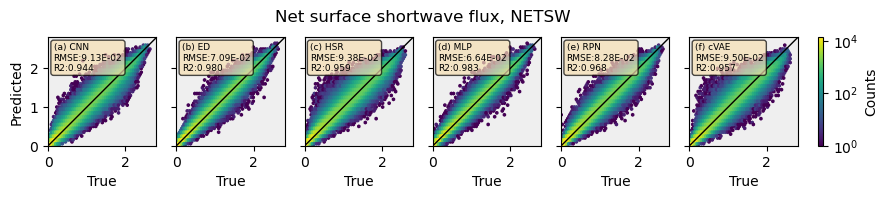

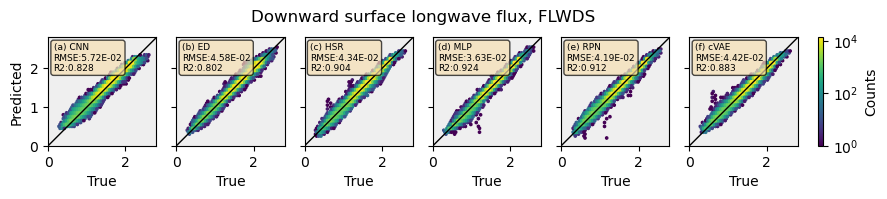

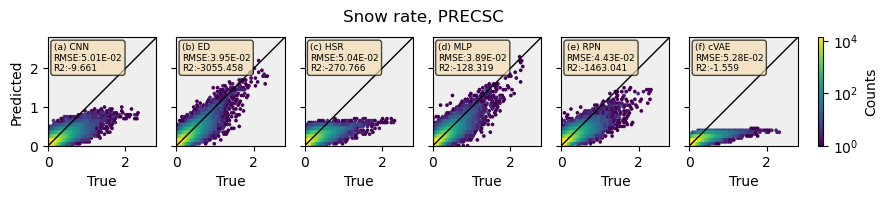

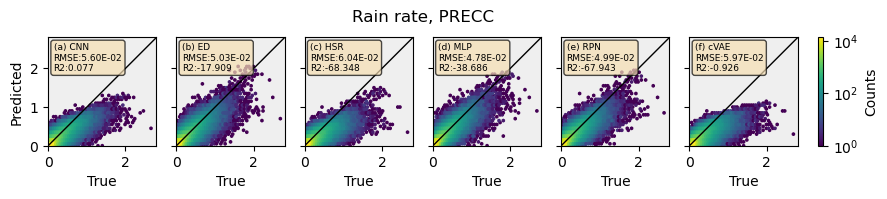

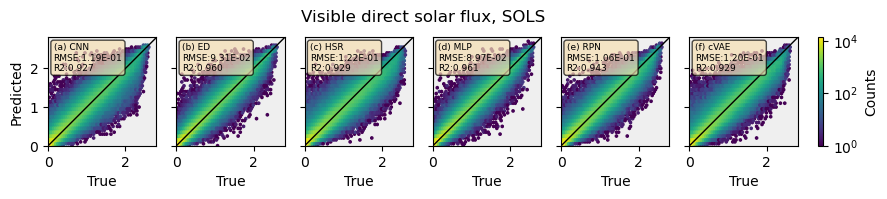

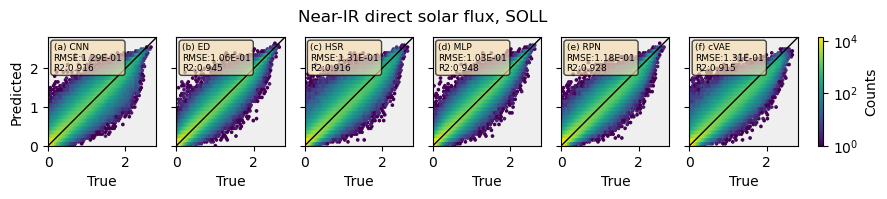

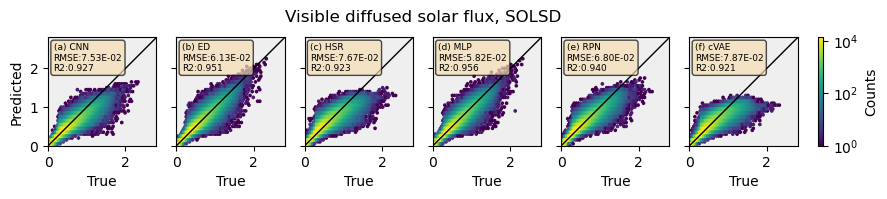

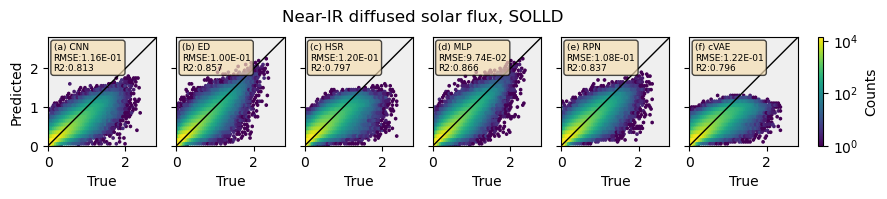

In [29]:
# plot 2d variables
for kvar in ['cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']:
    plot_hexbin(kvar,
            xmin=0, xmax=2.8,
            ymin=0, ymax=2.8)

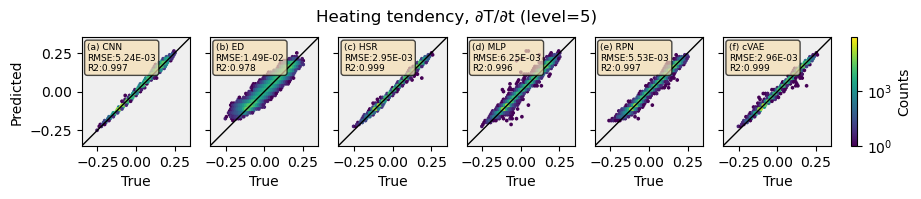

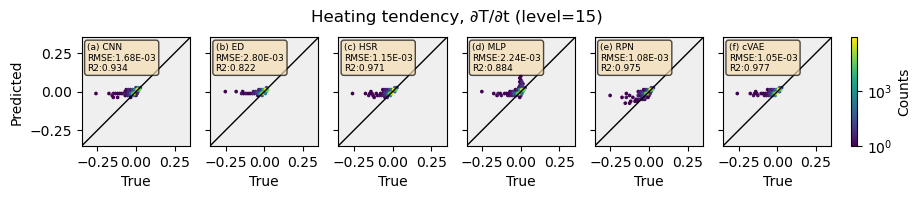

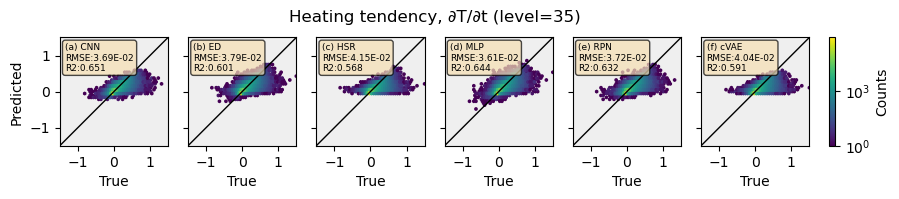

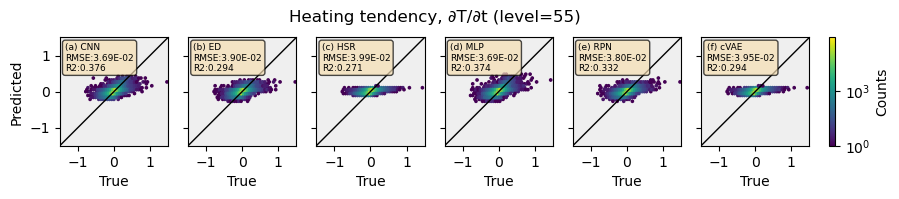

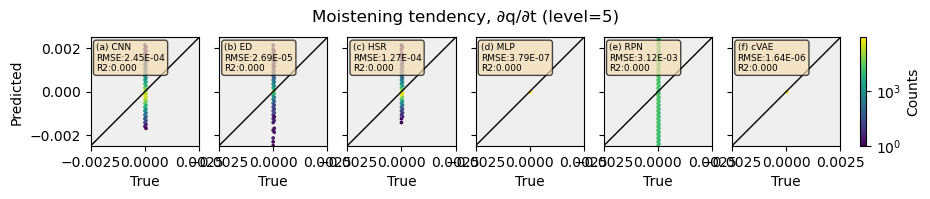

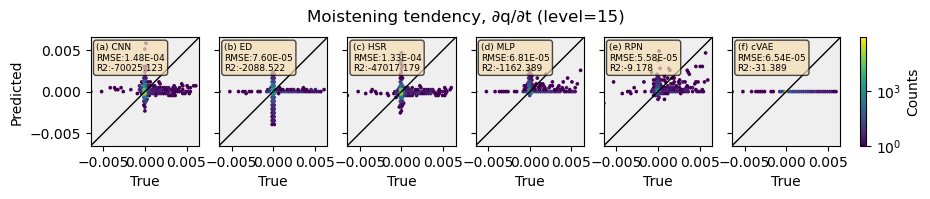

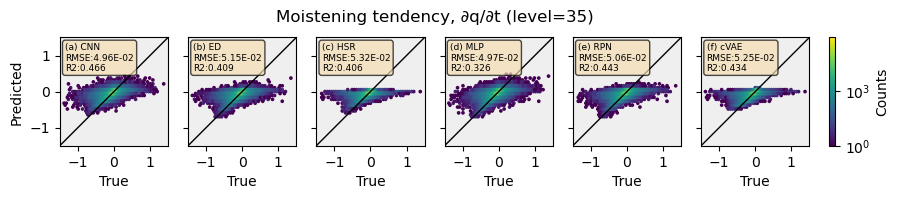

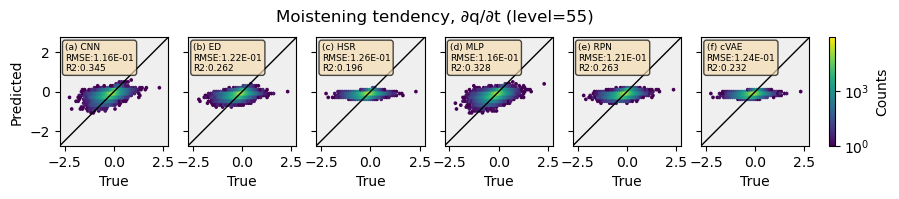

In [30]:
# plot 3d variables
plot_hexbin('ptend_t', klev=5,
            xmin=-.35, xmax=.35,
            ymin=-.35, ymax=.35)
plot_hexbin('ptend_t', klev=15,
            xmin=-.35, xmax=.35,
            ymin=-.35, ymax=.35)
plot_hexbin('ptend_t', klev=35,
            xmin=-1.5, xmax=1.5,
            ymin=-1.5, ymax=1.5)
plot_hexbin('ptend_t', klev=55,
            xmin=-1.5, xmax=1.5,
            ymin=-1.5, ymax=1.5)

plot_hexbin('ptend_q0001', klev=5,
            xmin=-.0025, xmax=.0025,
            ymin=-.0025, ymax=.0025)
plot_hexbin('ptend_q0001', klev=15,
            xmin=-.0065, xmax=.0065,
            ymin=-.0065, ymax=.0065)
plot_hexbin('ptend_q0001', klev=35,
            xmin=-1.5, xmax=1.5,
            ymin=-1.5, ymax=1.5)
plot_hexbin('ptend_q0001', klev=55,
            xmin=-2.75, xmax=2.75,
            ymin=-2.75, ymax=2.75)